In [5]:
fullPath = './clinvar.annotation.with_dbnsfp_new.dedup.tsv.gz'

trainSplitPath = './clinvar.annotation.with_dbnsfp_new.dedup.train.tsv.gz'
testSplitPath = './clinvar.annotation.with_dbnsfp_new.dedup.test.tsv.gz'

trainNormPath = './clinvar.annotation.with_dbnsfp_new.dedup.train.norm.tsv.gz'
testNormPath = './clinvar.annotation.with_dbnsfp_new.dedup.test.norm.tsv.gz'

trainNormPandasPath = './clinvar.annotation.with_dbnsfp_new.dedup.train.norm.one_hot.tsv.gz'
testNormPandasPath = './clinvar.annotation.with_dbnsfp_new.dedup.test.norm.one_hot.tsv.gz'

trainPath = './clinvar.annotation.with_dbnsfp_new.dedup.train.norm.one_hot.de_correlated.tsv.gz'
testPath = './clinvar.annotation.with_dbnsfp_new.dedup.test.norm.one_hot.de_correlated.tsv.gz'

from xgboost import XGBClassifier

In [6]:
from pandas import read_csv
cDataTrain = read_csv(trainPath, sep='\t', low_memory=False)
cDataTest = read_csv(testPath, sep='\t', low_memory=False)

trainLabels = cDataTrain['pathogenic']
testLabels = cDataTest['pathogenic']

cDataTrain = cDataTrain.drop(['pathogenic'], axis=1)
cDataTest = cDataTest.drop(['pathogenic'], axis=1)

In [9]:
### Helper functions to display results, borrowed

# function takes a RF parameter and a ranger and produces a plot and dataframe of CV scores for parameter values
# https://www.kaggle.com/hadend/tuning-random-forest-parameters
def evaluate_param(parameter, num_range, index):
    grid_search = GridSearchCV(clf, param_grid = {parameter: num_range})
    grid_search.fit(X_train[features], y_train)
    
    df = {}
    for i, score in enumerate(grid_search.grid_scores_):
        df[score[0][parameter]] = score[1]
       
    
    df = pd.DataFrame.from_dict(df, orient='index')
    df.reset_index(level=0, inplace=True)
    df = df.sort_values(by='index')
 
    plt.subplot(3,2,index)
    plot = plt.plot(df['index'], df[0])
    plt.title(parameter)
    return plot, df



In [8]:
import pandas as pd
from pandas import read_csv
import numpy as np
import os.path
import sys

def oneHotEncode(filePath, outPath, impute = True):
    cData = read_csv(filePath, sep='\t', low_memory=False)
    
    # site type is redundant with exonicallelefunction after perl normalization
    # altAminoAcid and refAminoAcid are accounted for in the conditional and essential disruption variables
    cData = cData.drop(['refSeq.name', 'refSeq.codonNumber', 'refSeq.siteType', 'refSeq.refAminoAcid', 'refSeq.altAminoAcid'], axis=1)

    catVariables = ['type', 'alt', 'ref','refSeq.exonicAlleleFunction']

    cats = cData[catVariables].copy()

    oneHot = pd.get_dummies(cats, columns=catVariables)
    # Name will have very many categories, on the order of 60,000 genome-wide
    # exit;
    cData = cData.drop(catVariables, axis=1)
    
    if impute == True:
        cData = cData.fillna(cData.median())
        print(cData.isnull().sum())

    cData = cData.join(oneHot)

    cData.to_csv(path_or_buf = outPath, sep = "\t", index = False, compression = 'gzip')

# Adapter from https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
def createRandomSplit(fullPath, trainOutPath, testOutPath, trainSplit = .75):
    np.random.seed(0)
    cData = read_csv(fullPath, sep='\t', low_memory=False)

    perm = np.random.permutation(cData.index)
    trainStop = int(len(cData) * trainSplit)
    train = cData.iloc[perm[:trainStop]]
    test = cData.iloc[perm[trainStop:]]

    train.to_csv(path_or_buf = trainOutPath, sep = "\t", compression = 'gzip', index=False)
    test.to_csv(path_or_buf = testOutPath, sep = "\t", compression = 'gzip', index=False)

if os.path.isfile(trainSplitPath) == False or os.path.isfile(testSplitPath) == False:
    createRandomSplit(fullPath, trainSplitPath, testSplitPath)
    sys.exit("Now normalize")

if os.path.isfile(trainNormPath) == False or os.path.isfile(testNormPath) == False:
    sys.exit("Now normalize")

if os.path.isfile(trainNormPandasPath) == False or os.path.isfile(testNormPandasPath) == False:
    oneHotEncode(trainNormPath, trainNormPandasPath)
    oneHotEncode(testNormPath, testNormPandasPath)


./clinvar.annotation.with_dbnsfp_new.dedup.train.norm.one_hot.tsv.gz
['gnomad.af_amr', 'gnomad.af_asj', 'gnomad.af_fin', 'gnomad.af_nfe', 'gnomad.af_oth', 'gnomad.af_male', 'gnomad.af_female', 'alt_+', 'alt_-']
              chrom           pos    pathogenic  refSeq.strand     phastCons  \
count  1.146629e+06  1.146629e+06  1.146629e+06   1.146629e+06  1.146629e+06   
mean   1.057468e+01  7.280862e+07  2.599699e-01   4.518035e-01  5.883808e-01   
std    6.840137e+00  5.756895e+07  4.386180e-01   4.976719e-01  4.671763e-01   
min    1.000000e+00  9.308300e+04  0.000000e+00   0.000000e+00  0.000000e+00   
25%    3.000000e+00  3.295364e+07  0.000000e+00   0.000000e+00  0.000000e+00   
50%    1.000000e+01  5.074063e+07  0.000000e+00   0.000000e+00  9.800000e-01   
75%    1.700000e+01  1.101021e+08  1.000000e+00   1.000000e+00  1.000000e+00   
max    2.400000e+01  2.486519e+08  1.000000e+00   1.000000e+00  1.000000e+00   

             phyloP          cadd  dbSNP.alleleFreqs     gnomad.af  

<IPython.core.display.Javascript object>


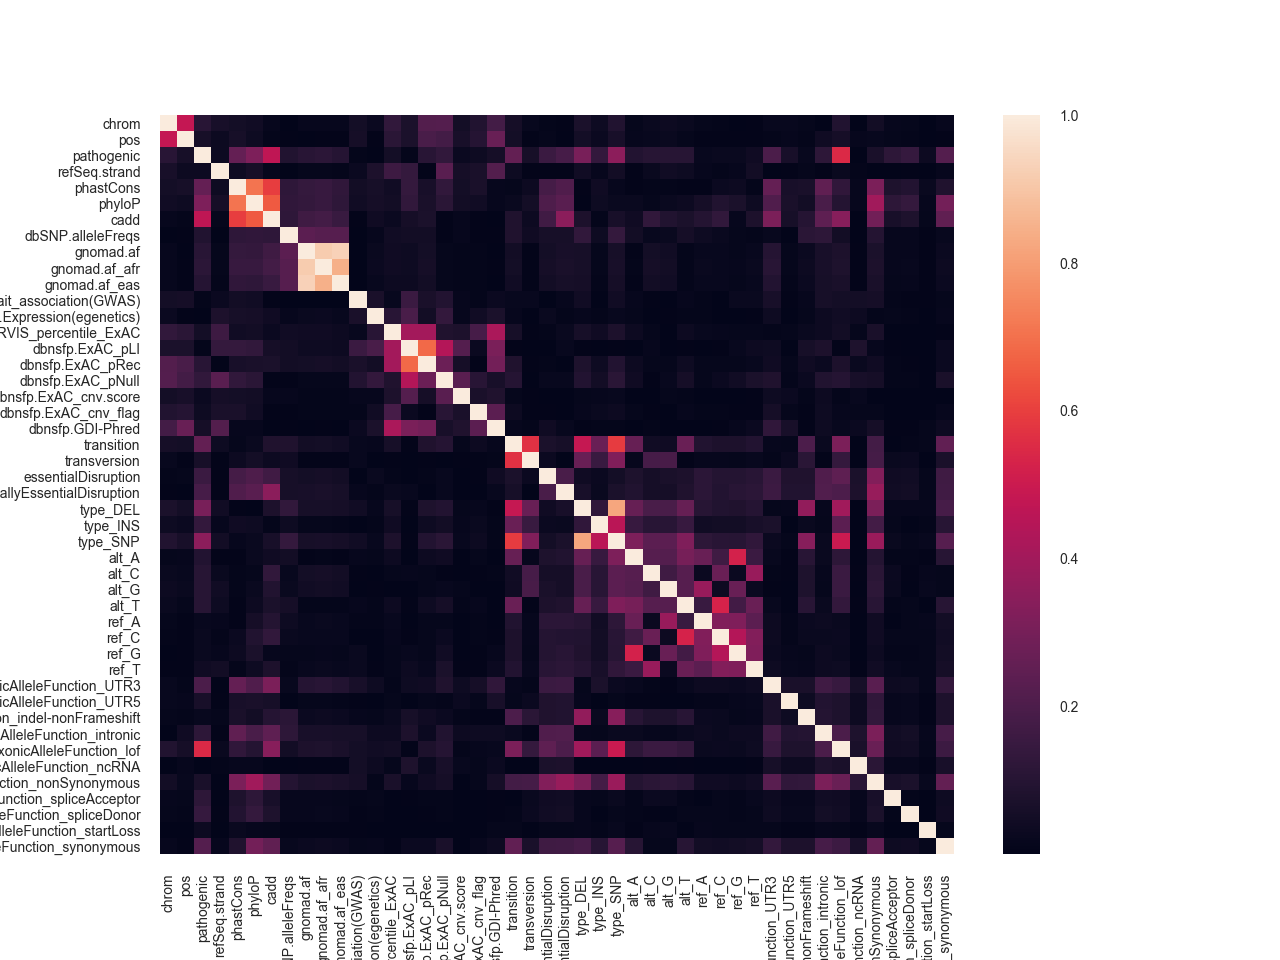

In [5]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import os.path

import pandas as pd
from pandas import read_csv
import numpy as np

cDataTrain = read_csv(trainNormPandasPath, sep='\t', low_memory=False)

corr = cDataTrain.corr().abs()

# Heatmap of correlation on training data
sns.set(font_scale=.5)

# Adapted from https://chrisalbon.com/machine-learning/drop_highly_correlated_features.html

upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(to_drop)

cDataTrain = cDataTrain.drop(to_drop, axis=1)

if os.path.isfile(trainPath) == False or os.path.isfile(testPath) == False:
    cDataTrain.to_csv(path_or_buf = trainPath, sep = "\t", compression = 'gzip', index=False)
    
    cDataTest = read_csv(testNormPandasPath, sep='\t', low_memory=False)
    cDataTest = cDataTest.drop(to_drop, axis=1)
    
    cDataTest.to_csv(path_or_buf=testPath, sep = "\t", compression = "gzip", index = False)


# Look at correlation again
corr = cDataTrain.corr().abs()

# Heatmap of correlation on training data after pruning correlated features
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

The scikit-learn version is 0.19.1.
[0 0 0 ..., 0 0 0]
('TP:', 81634, ' TN:', 264295, ' T1Err:', 15056, ' T2Err:', 19947)
(0.84428586203330236, 0.80363453795493256)
TN: 264295, FP: 15056, FN: 19947, TP: 81634
[ 0.0206751   0.05292163  0.00418368  0.0246454   0.05867743  0.14812515
  0.04815997  0.0744869   0.01855615  0.00419632  0.01697108  0.02071741
  0.0274317   0.02266346  0.02513673  0.02575008  0.02163089  0.00322167
  0.0300417   0.01384382  0.00492141  0.00749497  0.00985798  0.01800366
  0.003655    0.0445862   0.00214153  0.0019845   0.00223575  0.00239815
  0.00233463  0.00273643  0.00262488  0.00237924  0.01304539  0.00135374
  0.00836707  0.00576101  0.15359463  0.00143025  0.02120518  0.00736356
  0.0098634   0.00069872  0.00792644]
{'warm_start': False, 'oob_score': False, 'n_jobs': 8, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 201, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0,

<IPython.core.display.Javascript object>


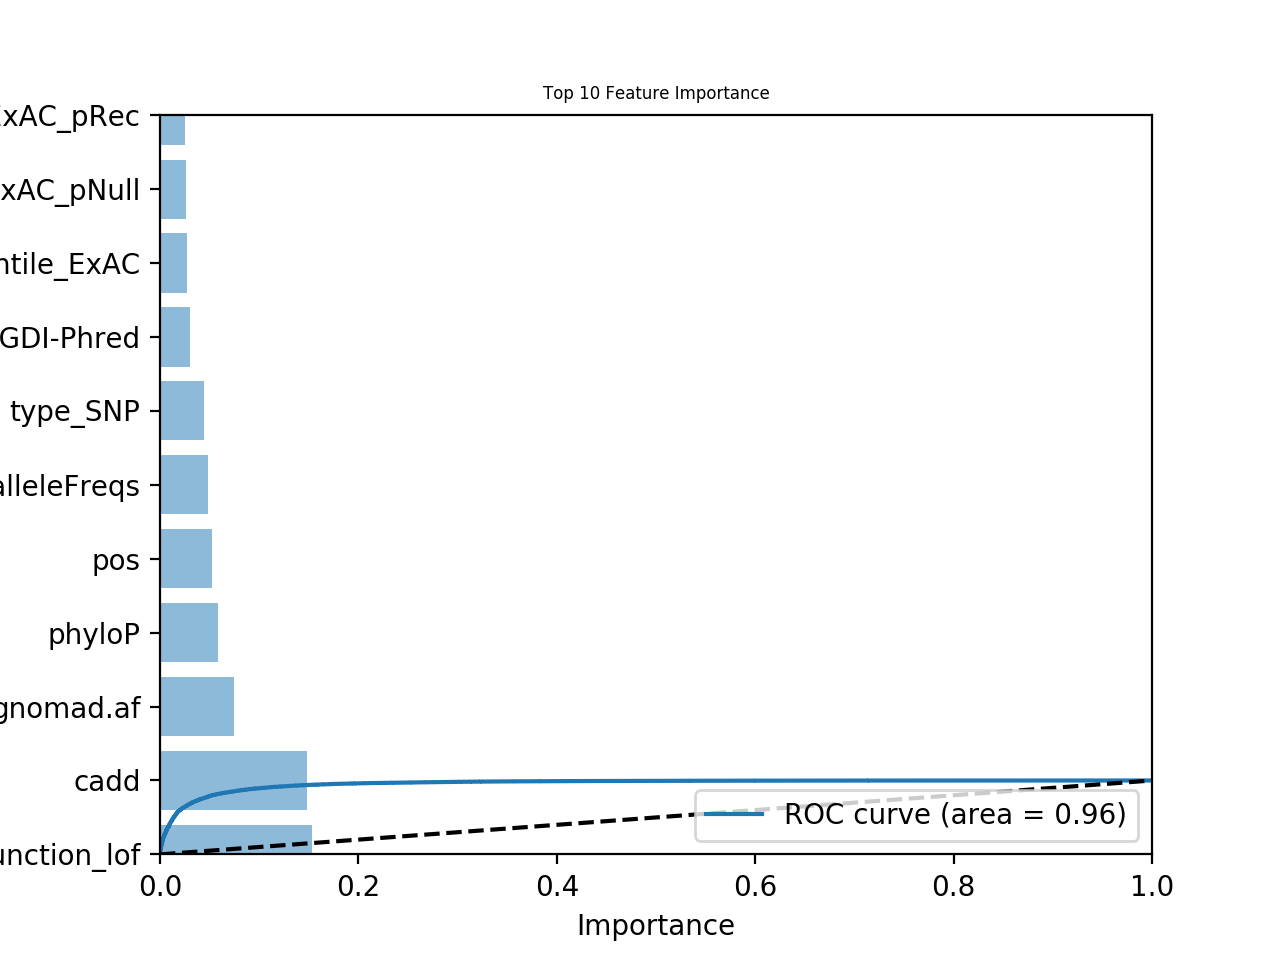

In [19]:
#Note: graph in output was unfortunately mutated by the subsequent cell's graph
#Correct graph found in paper, and in results folder
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import scipy
import sklearn

from pandas import read_csv
#from sklearn-pandas import DataFrameMapper, c
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy import sparse
import os.path
import sys
from sklearn import metrics
from scipy.stats import randint as sp_randint
import time
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,roc_curve,auc

# https://medium.com/rants-on-machine-learning/smarter-parameter-sweeps-or-why-grid-search-is-plain-stupid-c17d97a0e881
# Better than grid
from sklearn.model_selection import RandomizedSearchCV

print('The scikit-learn version is {}.'.format(sklearn.__version__))

def classifyRandomForest(trainPath, testPath, isSparse = False):
    cDataTrain = read_csv(trainPath, sep='\t', low_memory=False)
    cDataTest = read_csv(testPath, sep='\t', low_memory=False)

    trainLabels = cDataTrain['pathogenic']
    testLabels = cDataTest['pathogenic']

    cDataTrain = cDataTrain.drop(['pathogenic'], axis=1)
    cDataTest = cDataTest.drop(['pathogenic'], axis=1)
    
    if isSparse == True:
        cDataTrain = sparse.csr_matrix(cDataTrain.to_sparse().to_coo())
        cDataTest = sparse.csr_matrix(cDataTest.to_sparse().to_coo())

    # Default; From Nasim's OOB curve, 25 may be best
    # .94 AUC with n_estimators = 10
    # .95 AUC with n_estimators = 25
    # Best results using 10 iter, 5 fold cv
    # ('RandomSearchCv best params', {'max_features': 'sqrt', 'n_estimators': 201, 'n_jobs': 8, 'min_samples_leaf': 9})
    clf = RandomForestClassifier(n_estimators = 201, min_samples_leaf = 9, n_jobs = 8, random_state = 0)

    #scores = cross_val_score(clf, cDataTrain, trainLabels, cv = 5, scoring='precision')
    #print(scores)
    clf.fit(cDataTrain, trainLabels)

    predictions = clf.predict(cDataTest)
    print(predictions)
    
    precision = metrics.precision_score(testLabels,predictions)
    recall = metrics.recall_score(testLabels,predictions)

    print (precision, recall)
    
    tn, fp, fn, tp = metrics.confusion_matrix(testLabels, predictions).ravel()
    print("TN: %d, FP: %d, FN: %d, TP: %d" % (tn, fp, fn, tp))
    
    print(clf.feature_importances_)
    print(clf.get_params())

    # Determine the false positive and true positive rates
    fpr, tpr, _ = roc_curve(testLabels, clf.predict_proba(cDataTest)[:,1])

    # Calculate the AUC
    roc_auc = auc(fpr, tpr)
    print 'ROC AUC: %0.2f' % roc_auc

    # Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return predictions, clf, testLabels, cDataTest


rfPredict, rfModel, rfTestLabels, rfTestData = classifyRandomForest(trainPath, testPath)

feature: refSeq.exonicAlleleFunction_lof, importance: 0.153594627012
feature: cadd, importance: 0.148125149247
feature: gnomad.af, importance: 0.0744869035038
feature: phyloP, importance: 0.0586774348054
feature: pos, importance: 0.0529216341259
feature: dbSNP.alleleFreqs, importance: 0.0481599699954
feature: type_SNP, importance: 0.0445861965912
feature: dbnsfp.GDI-Phred, importance: 0.0300416952914
feature: dbnsfp.RVIS_percentile_ExAC, importance: 0.0274316986293
feature: dbnsfp.ExAC_pNull, importance: 0.0257500793504
feature: dbnsfp.ExAC_pRec, importance: 0.025136734273
feature: phastCons, importance: 0.0246454037485
feature: dbnsfp.ExAC_pLI, importance: 0.0226634608849
feature: dbnsfp.ExAC_cnv.score, importance: 0.0216308893966
feature: refSeq.exonicAlleleFunction_nonSynonymous, importance: 0.0212051810486
feature: dbnsfp.Expression(egenetics), importance: 0.0207174116227
feature: chrom, importance: 0.0206750985446
feature: gnomad.af_afr, importance: 0.0185561498856
feature: type_D

<IPython.core.display.Javascript object>


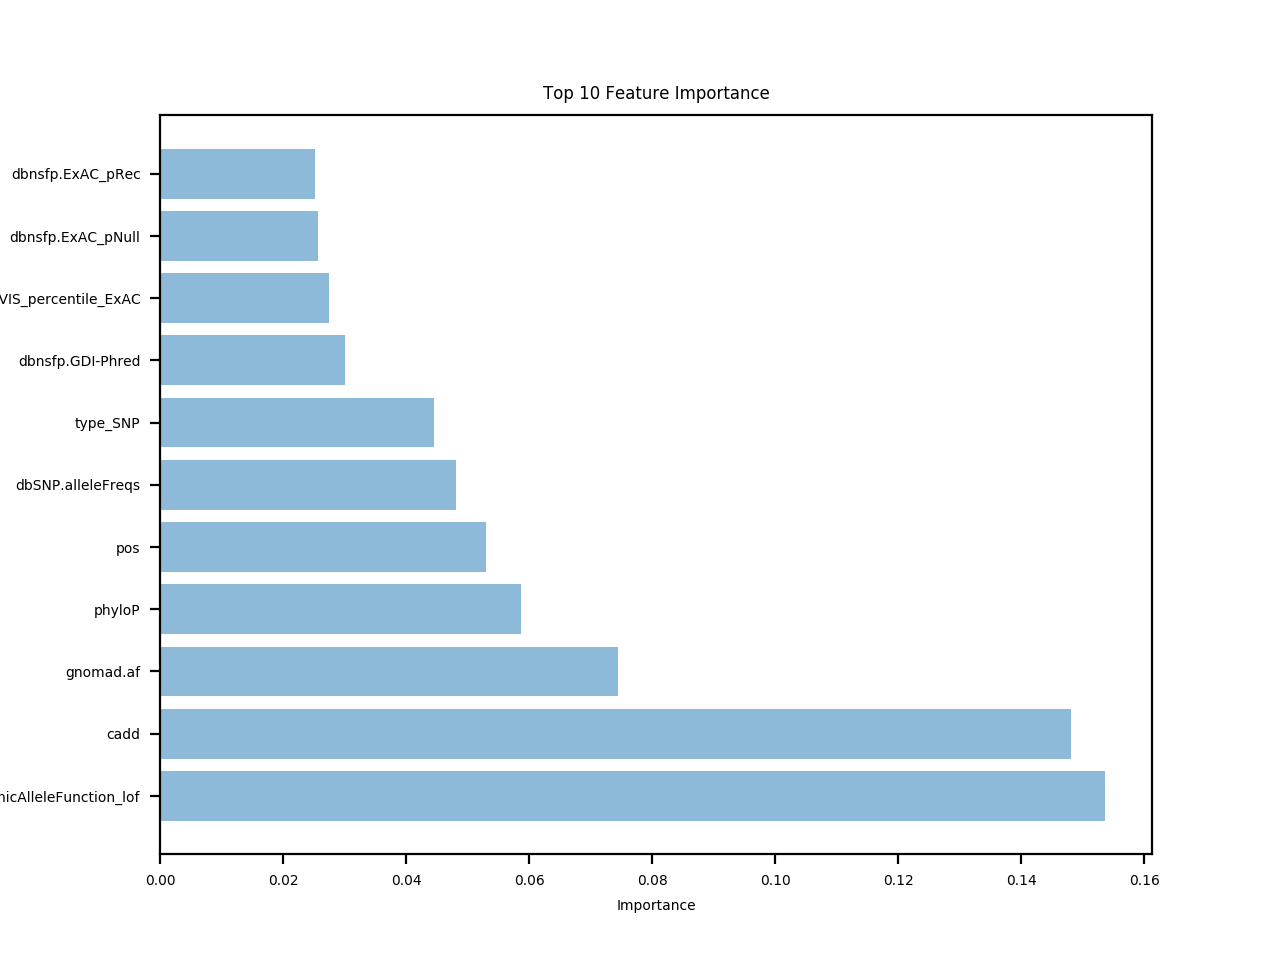

In [21]:
# Show feature importance
import matplotlib.pyplot as plt
# rfPredict, rfModel, rfTestLabels, rfTestData

featuresImportance = zip(rfTestData.columns, rfModel.feature_importances_)

features = []
importances = []
for feat, importance in sorted(featuresImportance, key = lambda t: t[1], reverse=True):
    print 'feature: {f}, importance: {i}'.format(f=feat, i=importance)
    features.append(feat)
    importances.append(importance)

classification_report(rfTestLabels, rfPredict)

print(features)
print(importances)
matplotlib.rcParams.update({'font.size': 5})

# Plot features
yPos = np.arange(len(features))

plt.barh(yPos[0:11], importances[0:11], align='center', alpha=0.5)
plt.yticks(yPos[0:11], features[0:11])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')

plt.show()

The scikit-learn version is 0.19.1.
   chrom       pos  pathogenic  refSeq.strand  phastCons  phyloP   cadd  \
0      8  90993087           0            0.0       1.00    7.40  26.30   
1      8  90993087           0            0.0       1.00    7.40  26.30   
2      8  90993088           0            0.0       0.97    0.08   8.45   
3      8  90993088           0            0.0       0.97    0.08   8.45   
4      8  90993089           0            0.0       1.00    7.81  29.70   

   dbSNP.alleleFreqs  gnomad.af  gnomad.af_afr  \
0           0.000033   0.000028       0.000131   
1           0.000033   0.000028       0.000131   
2           0.000033   0.000028       0.000131   
3           0.000033   0.000028       0.000131   
4           0.000033   0.000028       0.000131   

                    ...                    refSeq.exonicAlleleFunction_UTR5  \
0                   ...                                                   0   
1                   ...                               

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 104.4min finished


('RandomSearchCv best params', {'max_features': 'sqrt', 'n_estimators': 201, 'n_jobs': 8, 'min_samples_leaf': 9})
[0 0 0 ..., 0 0 0]
(0.84436329026184298, 0.8034671838237466)
('Confusion matrix: ', array([[264307,  15044],
       [ 19964,  81617]]))
ROC AUC: 0.96


<IPython.core.display.Javascript object>


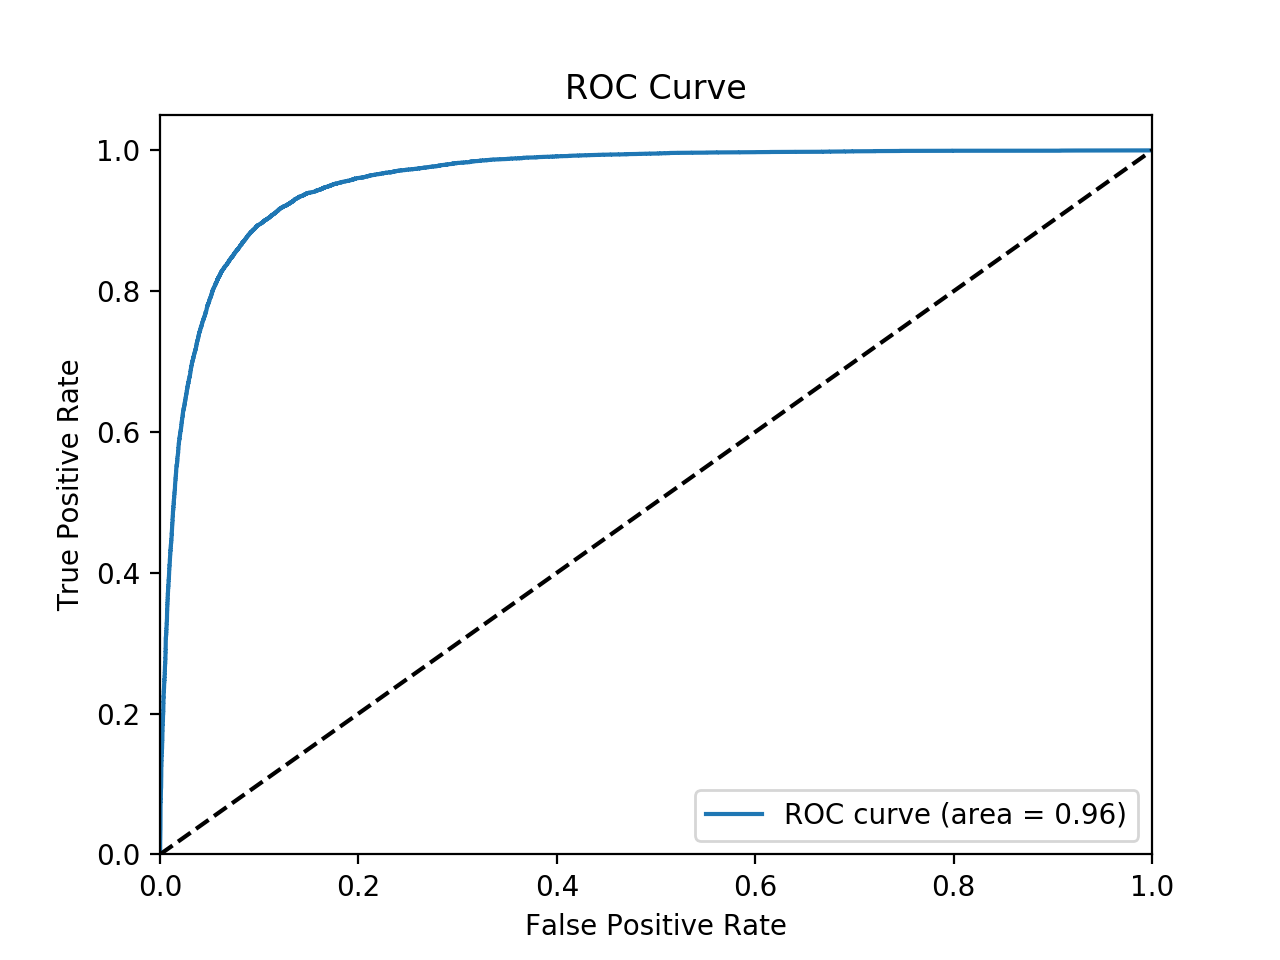

In [11]:
########### Random forest with CV using Randomized Search #### ######
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import scipy
import sklearn

from pandas import read_csv
#from sklearn-pandas import DataFrameMapper, c
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy import sparse
import os.path
import sys
from sklearn import metrics
from scipy.stats import randint as sp_randint
import time
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,roc_curve,auc

# https://medium.com/rants-on-machine-learning/smarter-parameter-sweeps-or-why-grid-search-is-plain-stupid-c17d97a0e881
# Better than grid
from sklearn.model_selection import RandomizedSearchCV

print('The scikit-learn version is {}.'.format(sklearn.__version__))


def classifyRandomForestWithRandomize(trainPath, testPath, isSparse = False):
    cDataTrain = read_csv(trainPath, sep='\t', low_memory=False)
    cDataTest = read_csv(testPath, sep='\t', low_memory=False)
    print(cDataTest.head())

    trainLabels = cDataTrain['pathogenic']
    testLabels = cDataTest['pathogenic']
    
    cDataTrain = cDataTrain.drop(['pathogenic'], axis=1)
    cDataTest = cDataTest.drop(['pathogenic'], axis=1)
    
    if isSparse == True:
        cDataTrain = sparse.csr_matrix(cDataTrain.to_sparse().to_coo())
        cDataTest = sparse.csr_matrix(cDataTest.to_sparse().to_coo())

    clf = RandomForestClassifier()
    
    # Best result:
    # ('RandomSearchCv best params', {'max_features': 'sqrt', 'n_estimators': 201, 'n_jobs': 8, 'min_samples_leaf': 9})
    param_dist = {
        # Relates to overfitting (more features, more overfit)
              "max_features": ["sqrt", "log2"],
        # Relates to overfitting (smaller, more likely to be deep tree, overfit)
              "min_samples_leaf": sp_randint(1, 11),
        # Reduces likelihood of overfitting if large
              "n_estimators": sp_randint(10, 500),
              "n_jobs": [8]
             }

    # run randomized search
    n_iter_search = 10
    clf = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search, scoring="f1", cv=5, verbose=1)

    clf.fit(cDataTrain, trainLabels)
        
    print("RandomSearchCv best params", clf.best_params_)
        
    predictions = clf.predict(cDataTest)
    print(predictions)

    precision = metrics.precision_score(testLabels,predictions)
    recall = metrics.recall_score(testLabels,predictions)
        
    print (precision, recall)
    print ("Confusion matrix: ", metrics.confusion_matrix(testLabels, predictions))
    
    # Determine the false positive and true positive rates
    fpr, tpr, _ = roc_curve(testLabels, clf.predict_proba(cDataTest)[:,1])

    # Calculate the AUC
    roc_auc = auc(fpr, tpr)
    print 'ROC AUC: %0.2f' % roc_auc

    # Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return clf

results = classifyRandomForestWithRandomize(trainPath, testPath)


[0 0 0 ..., 0 0 0]
(0.84445854787032582, 0.81212037684212601)
TN: 264156, FP: 15195, FN: 19085, TP: 82496
[ 0.03480385  0.16131164  0.00605418  0.02079012  0.07632262  0.08577268
  0.04047389  0.05281274  0.01808571  0.01193934  0.03004041  0.04059681
  0.05419567  0.04110389  0.04001291  0.04543708  0.04781881  0.00373392
  0.05713056  0.00669955  0.00433319  0.00384148  0.00476344  0.00934249
  0.00570076  0.00948078  0.00510149  0.00468661  0.00468661  0.0049171
  0.00367246  0.00359563  0.00376466  0.00410271  0.00325758  0.00169025
  0.00691467  0.00497856  0.01187787  0.00124464  0.00888151  0.00522442
  0.00517832  0.00225879  0.00136757]
{'reg_alpha': 0, 'n_jobs': 4, 'colsample_bytree': 1, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.05, 'missing': None, 'max_delta_step': 0, 'nthread': None, 'base_score': 0.5, 'n_estimators': 425, 'subsample': 1, 'reg_lambda': 1, 'random_state': 0, 'min_child_weight': 1, 'objective': 'binary:logistic', 'seed

<IPython.core.display.Javascript object>


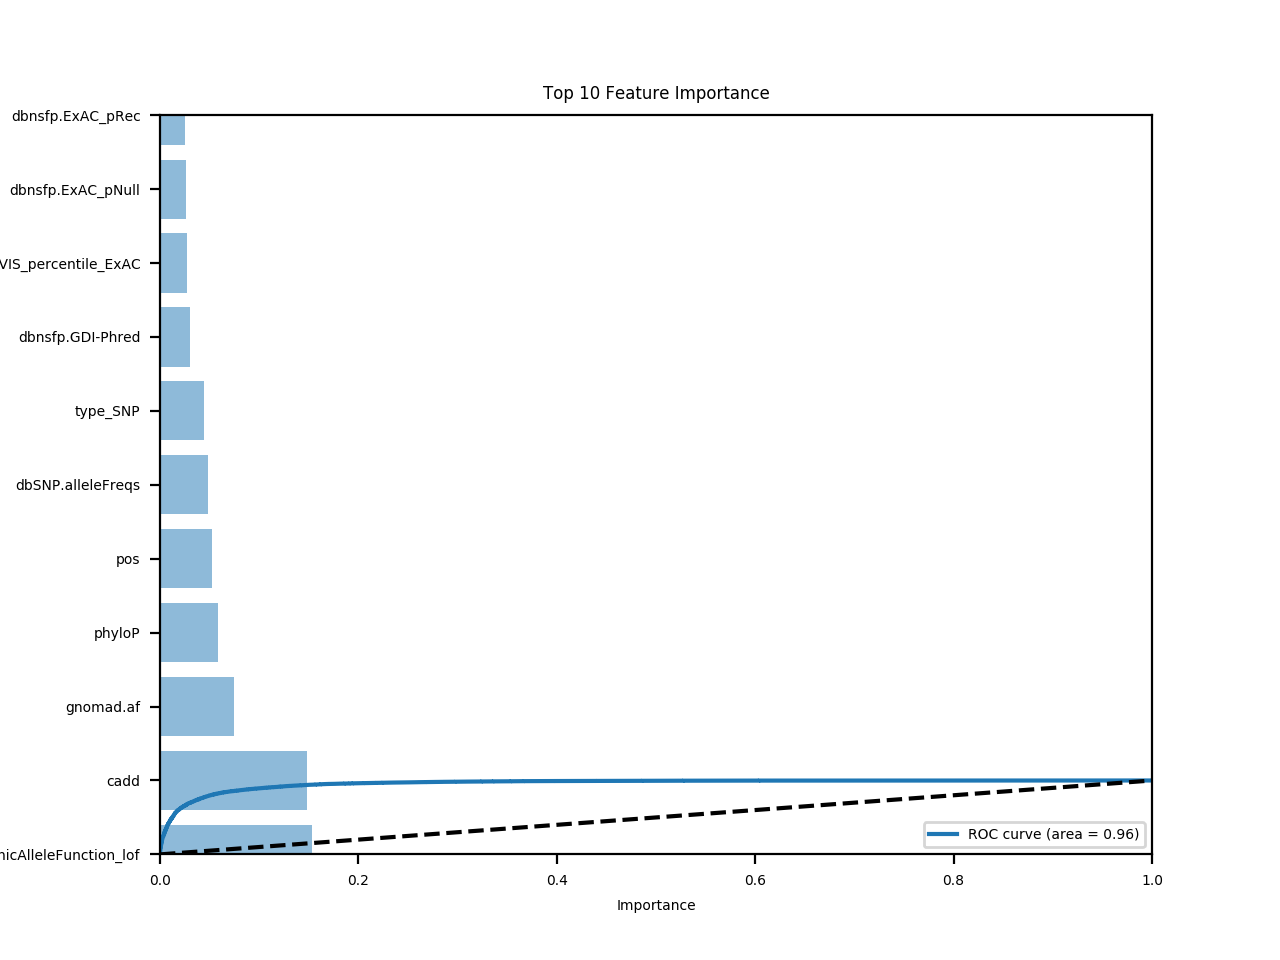

In [22]:
#Use the most favorable parameters for XGBoost, when using 10 iterations of cv = 5
%matplotlib notebook
import matplotlib
import numpy as np
import matplotlib.pyplot as plt


def classifyXGBoost():
    # Best based on 5 iteration, 3 fold CV
    # clf = XGBClassifier(n_jobs=64,learning_rate=.05,max_depth=9,n_estimators=342)
    # Best based on 10 iteration, 5 fold
    # clf = XGBClassifier(learning_rate=.05,max_depth=8,n_estimators=425)
    clf = XGBClassifier(n_jobs=4, learning_rate=.05, max_depth=8, n_estimators=425, random_state = 0)
    
    clf.fit(cDataTrain, trainLabels)
    
    #scores = cross_val_score(clf, cDataTrain, trainLabels, cv = 5, scoring='precision')
    #print(scores)
    clf.fit(cDataTrain, trainLabels)

    predictions = clf.predict(cDataTest)
    print(predictions)
    
    precision = metrics.precision_score(testLabels,predictions)
    recall = metrics.recall_score(testLabels,predictions)
    
    print (precision, recall)

    tn, fp, fn, tp = metrics.confusion_matrix(testLabels, predictions).ravel()
    print("TN: %d, FP: %d, FN: %d, TP: %d" % (tn, fp, fn, tp))

    print(clf.feature_importances_)

    print(clf.get_params())
    
    featuresImportance = zip(cDataTrain.columns, clf.feature_importances_)
    
    features = []
    importances = []
    for feat, importance in sorted(featuresImportance, key = lambda t: t[1], reverse=True):
        print( 'feature: {f}, importance: {i}'.format(f=feat, i=importance))
        features.append(feat)
        importances.append(importance)

    classification_report(testLabels, predictions)
    
    # Determine the false positive and true positive rates
    fpr, tpr, _ = roc_curve(testLabels, clf.predict_proba(cDataTest)[:,1])

    # Calculate the AUC
    # Adapted from sklearn docs
    roc_auc = auc(fpr, tpr)
    print('ROC AUC: %0.2f' % roc_auc)

    # Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return predictions, clf, testLabels, cDataTest


xgPredict, xgModel, xgTestLabels, xgTestData = classifyXGBoost()

feature: pos, importance: 0.161311641335
feature: cadd, importance: 0.085772678256
feature: phyloP, importance: 0.0763226225972
feature: dbnsfp.GDI-Phred, importance: 0.0571305640042
feature: dbnsfp.RVIS_percentile_ExAC, importance: 0.0541956685483
feature: gnomad.af, importance: 0.0528127364814
feature: dbnsfp.ExAC_cnv.score, importance: 0.0478188060224
feature: dbnsfp.ExAC_pNull, importance: 0.0454370826483
feature: dbnsfp.ExAC_pLI, importance: 0.041103888303
feature: dbnsfp.Expression(egenetics), importance: 0.0405968129635
feature: dbSNP.alleleFreqs, importance: 0.0404738858342
feature: dbnsfp.ExAC_pRec, importance: 0.0400129072368
feature: chrom, importance: 0.0348038524389
feature: dbnsfp.Trait_association(GWAS), importance: 0.0300404131413
feature: phastCons, importance: 0.0207901168615
feature: gnomad.af_afr, importance: 0.0180857107043
feature: gnomad.af_eas, importance: 0.0119393356144
feature: refSeq.exonicAlleleFunction_lof, importance: 0.0118778711185
feature: type_SNP, im

<IPython.core.display.Javascript object>


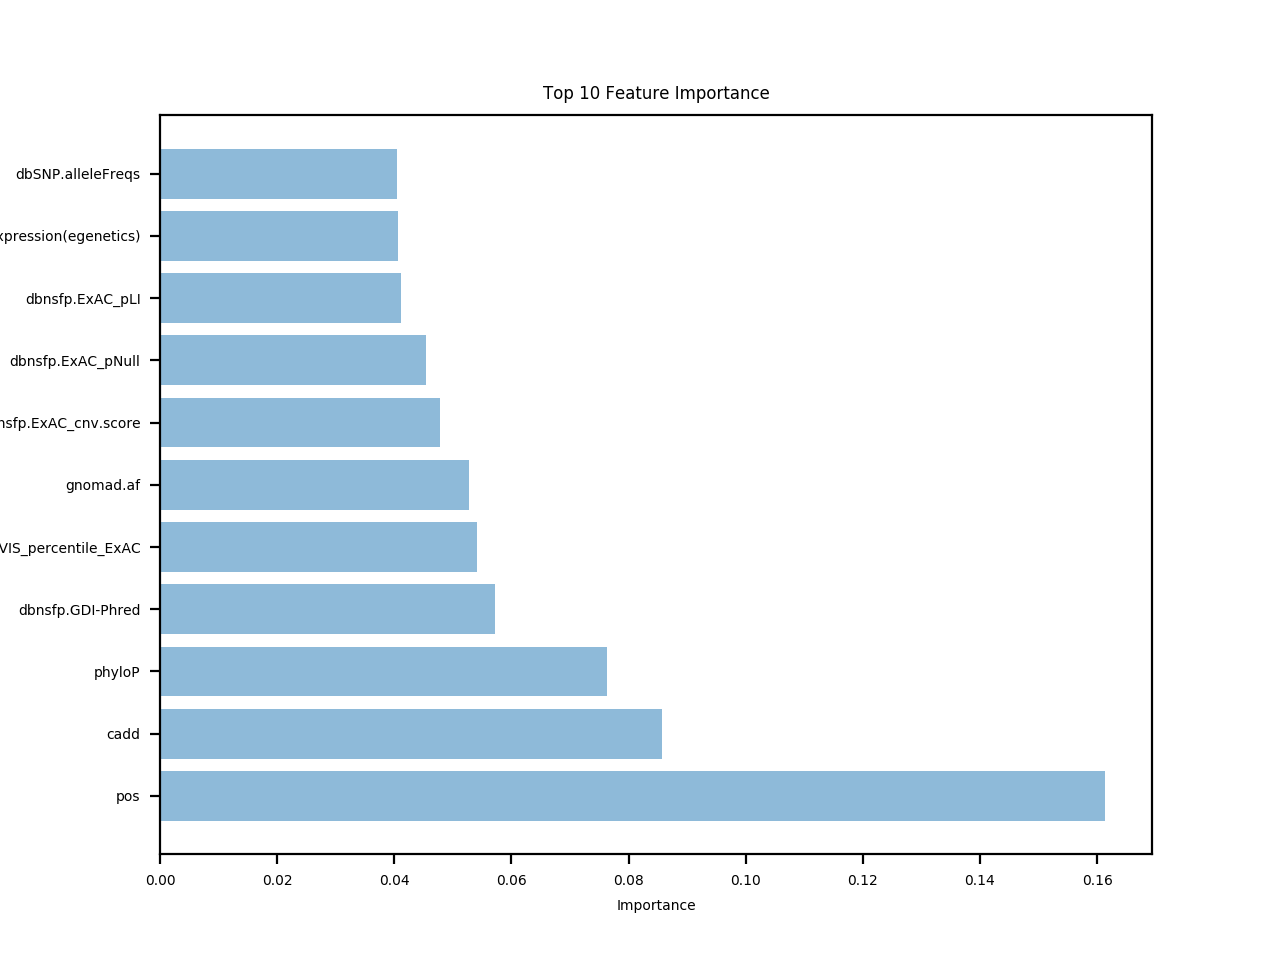

In [25]:
# Show feature importance
import matplotlib.pyplot as plt
# rfPredict, rfModel, rfTestLabels, rfTestData

featuresImportance = zip(xgTestData.columns, xgModel.feature_importances_)

features = []
importances = []
for feat, importance in sorted(featuresImportance, key = lambda t: t[1], reverse=True):
    print 'feature: {f}, importance: {i}'.format(f=feat, i=importance)
    features.append(feat)
    importances.append(importance)

classification_report(xgTestLabels, xgPredict)

print(features)
print(importances)
matplotlib.rcParams.update({'font.size': 5})

# Plot features
yPos = np.arange(len(features))

plt.barh(yPos[0:11], importances[0:11], align='center', alpha=0.5)
plt.yticks(yPos[0:11], features[0:11])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')

plt.show()

The scikit-learn version is 0.19.1.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=10, learning_rate=1, n_jobs=4, max_depth=7 .........
[CV]  n_estimators=10, learning_rate=1, n_jobs=4, max_depth=7, total=  10.7s
[CV] n_estimators=10, learning_rate=1, n_jobs=4, max_depth=7 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.5s remaining:    0.0s


[CV]  n_estimators=10, learning_rate=1, n_jobs=4, max_depth=7, total=   9.0s
[CV] n_estimators=10, learning_rate=1, n_jobs=4, max_depth=7 .........
[CV]  n_estimators=10, learning_rate=1, n_jobs=4, max_depth=7, total=  10.2s
[CV] n_estimators=10, learning_rate=1, n_jobs=4, max_depth=7 .........
[CV]  n_estimators=10, learning_rate=1, n_jobs=4, max_depth=7, total=  12.0s
[CV] n_estimators=10, learning_rate=1, n_jobs=4, max_depth=7 .........
[CV]  n_estimators=10, learning_rate=1, n_jobs=4, max_depth=7, total=  11.5s
[CV] n_estimators=27, learning_rate=0.05, n_jobs=4, max_depth=9 ......
[CV]  n_estimators=27, learning_rate=0.05, n_jobs=4, max_depth=9, total=  33.3s
[CV] n_estimators=27, learning_rate=0.05, n_jobs=4, max_depth=9 ......
[CV]  n_estimators=27, learning_rate=0.05, n_jobs=4, max_depth=9, total=  30.4s
[CV] n_estimators=27, learning_rate=0.05, n_jobs=4, max_depth=9 ......
[CV]  n_estimators=27, learning_rate=0.05, n_jobs=4, max_depth=9, total=  32.8s
[CV] n_estimators=27, lear

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 155.1min finished


('RandomSearchCv best params', {'n_estimators': 425, 'learning_rate': 0.05, 'n_jobs': 4, 'max_depth': 8})
[0 0 0 ..., 0 0 0]
(0.84445854787032582, 0.81212037684212601)
('reported: ', 97691, ' and total:', 380932)
(' Confusion matrix ', array([[264156,  15195],
       [ 19085,  82496]]))
ROC AUC: 0.96


<IPython.core.display.Javascript object>


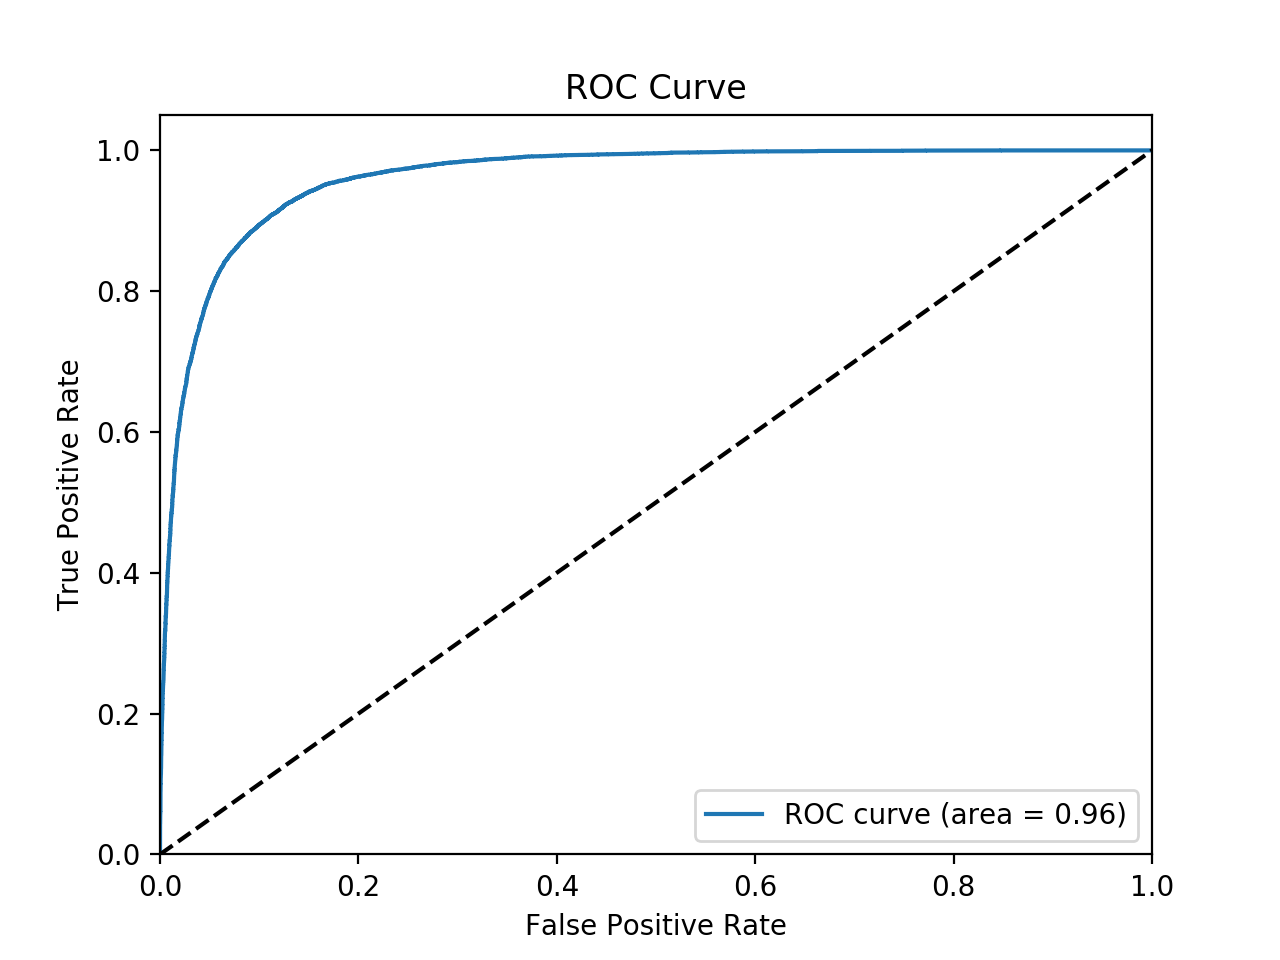

In [15]:
### XGBoost randomized search optimization
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import scipy
import sklearn

from pandas import read_csv
#from sklearn-pandas import DataFrameMapper, c
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy import sparse
import os.path
import sys
from sklearn import metrics
from scipy.stats import randint as sp_randint
import time
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,roc_curve,auc

# https://medium.com/rants-on-machine-learning/smarter-parameter-sweeps-or-why-grid-search-is-plain-stupid-c17d97a0e881
# Better than grid
from sklearn.model_selection import RandomizedSearchCV

print('The scikit-learn version is {}.'.format(sklearn.__version__))

def classifyXgboostWithGridSearch():
#     # # Create a random forest Classifier. By convention, clf means 'Classifier'
    clf = XGBClassifier()
    
    # specify parameters and distributions to sample from
    # Best apparently to use n_threads (n_jobs) == number of phyiscal corse
    param_dist = {
        "learning_rate": [0.05,1],
        "max_depth": sp_randint(3, 11),
        "n_estimators": sp_randint(10, 500),
        "n_jobs": [4]}
    
    # run randomized search
    n_iter_search = 10
    clf = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search, scoring="f1", n_jobs=1, cv=5, verbose = 2)

    # # Train the Classifier to take the training features and learn how they relate
    # # to the training y (the species)
    clf.fit(cDataTrain, trainLabels)
    
    print("RandomSearchCv best params", clf.best_params_)
 
    predictions = clf.predict(cDataTest)
    print(predictions)

    precision = metrics.precision_score(testLabels,predictions)
    recall = metrics.recall_score(testLabels,predictions)
        
    print (precision, recall)
    print( "reported: ", sum(predictions), ' and total:', len(predictions))
    print(" Confusion matrix ", metrics.confusion_matrix(testLabels, predictions))
    
    # Determine the false positive and true positive rates
    fpr, tpr, _ = roc_curve(testLabels, clf.predict_proba(cDataTest)[:,1])
    
    # Calculate the AUC
    roc_auc = auc(fpr, tpr)
    print('ROC AUC: %0.2f' % roc_auc)

    # Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return clf


resultXgBoostGrid = classifyXgboostWithGridSearch()


In [13]:
# Run FF NN, randomized search 5 iterations, 3-fold CV
# Note: Output corresponds to 10 iterations, 5-fold CV; this was attempted and cancelled
# Originally stated data was for 5 iterations, 3-fold CV, over the given parameter range
# Best result from this was hidden_layer_sizes = [20, 20], activation='logistic', solver='lbfgs'
import tensorflow
import random
from tflearn import DNN
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,roc_curve,auc

def classifyNN():
    # Do we need to scale our data?
    # Peformance drops when I do this, if my 
    # Maybe because all data already on same scale?
    # Interestingly, and maybe not surprisingly

    scaler = StandardScaler()

    scaler.fit(cDataTrain)
    cDataTrainScaled = scaler.transform(cDataTrain)
    cDataTestScaled = scaler.transform(cDataTest)

    # Grid search to optimize
    # Build a range of layer/node combinations
    # With the number of nodes per layer being equal at each layer
    # Could modify further of course
    layerNodes = []

    for i in range(3):
        for y in range(10,100,10):
            layers = []
            
            for l in range(i + 1):
                layers.append(y)
                layerNodes.append(layers)
    
    mlp = MLPClassifier()
    params = {
           'activation' : ['identity', 'logistic', 'tanh', 'relu'],
           'solver' : ['lbfgs', 'sgd', 'adam'],
           'hidden_layer_sizes' : layerNodes,
           'max_iter' : [2000]
       }

    n_iter_search = 5

    clf = RandomizedSearchCV(mlp, param_distributions=params, n_iter=n_iter_search, scoring="f1", n_jobs = 5, verbose=1)
    clf.fit(cDataTrainScaled, trainLabels)
        
    print("RandomSearchCv best params", clf.best_params_)

    predictions = clf.predict(cDataTestScaled)
    print(predictions)

    precision = metrics.precision_score(testLabels,predictions)
    recall = metrics.recall_score(testLabels,predictions)
        
    print(precision, recall)
    print("Confusion matrix ", metrics.confusion_matrix(testLabels, predictions))
    
    # Determine the false positive and true positive rates
    fpr, tpr, _ = roc_curve(testLabels, clf.predict_proba(cDataTestScaled)[:,1])

    # Calculate the AUC
    roc_auc = auc(fpr, tpr)
    print('ROC AUC: %0.2f' % roc_auc)

    # Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return clf

resultsNN = classifyNN()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


KeyboardInterrupt: 

   chrom       pos  refSeq.strand  phastCons  phyloP   cadd  \
0     18  28666717            0.0       0.02    2.75   1.31   
1     18  28666717            0.0       0.02    2.75   1.31   
2      5  35876300            1.0       0.00   -1.51   0.00   
3      5  35876300            1.0       0.00   -1.51   0.00   
4      2  50758502            0.0       1.00    9.81  29.50   

   dbSNP.alleleFreqs  gnomad.af  gnomad.af_afr  gnomad.af_eas  \
0           0.000010   0.000016       0.000066            0.0   
1           0.000010   0.000016       0.000066            0.0   
2           0.002486   0.002275       0.000000            0.0   
3           0.002486   0.002275       0.000000            0.0   
4           0.002000   0.000000       0.000000            0.0   

                    ...                    refSeq.exonicAlleleFunction_UTR5  \
0                   ...                                                   0   
1                   ...                                                 

<IPython.core.display.Javascript object>


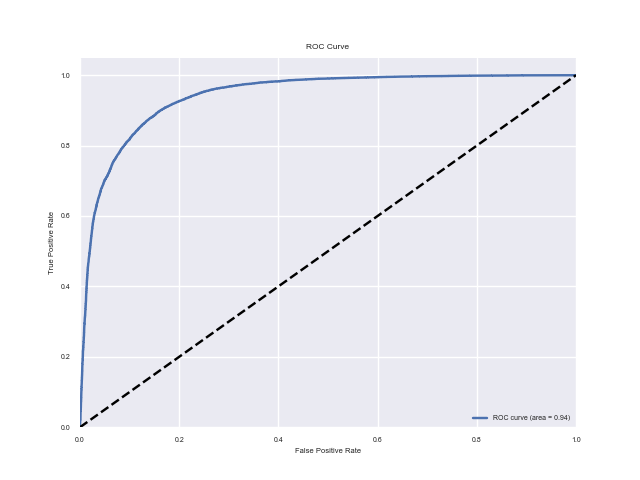

In [45]:
#Neural net with fixed values of 2 layers, 10 nodes, Sigmoid function
import tensorflow
import random
from tflearn import DNN
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

def classifyNNinitial():
    # Do we need to scale our data?
    # Peformance drops when I do this, if my 
    # Maybe because all data already on same scale?
    # Interestingly, and maybe not surprisingly

    scaler = StandardScaler()

    scaler.fit(cDataTrain)
    print(cDataTrain.head())
    cDataTrainScaled = scaler.transform(cDataTrain)
    cDataTestScaled = scaler.transform(cDataTest)
    print(cDataTrainScaled)

    #mlp.fit(X_train,y_train)
    #predictions = mlp.predict(X_test)
    #mlp.score(X_test,y_test)

    # Grid search to optimize
    # Build a range of layer/node combinations
    # With the number of nodes per layer being equal at each layer
    # Could modify further of course
    layerNodes = []

    for i in range(3):
        for y in range(10,100,10):
            layers = []
            
            for l in range(i + 1):
                layers.append(y)
                layerNodes.append(layers)
    
    clf = MLPClassifier(max_iter=2000, hidden_layer_sizes=[10, 10])

    clf.fit(cDataTrainScaled, trainLabels)
        
    predictions = clf.predict(cDataTestScaled)
    print(predictions)

    precision = metrics.precision_score(testLabels,predictions)
    recall = metrics.recall_score(testLabels,predictions)
        
    print (precision, recall)
    print( "reported: ", sum(predictions), ' and total:', len(predictions))
    print " Confusion matrix ", metrics.confusion_matrix(testLabels, predictions)
    
    # Determine the false positive and true positive rates
    fpr, tpr, _ = roc_curve(testLabels, clf.predict_proba(cDataTestScaled)[:,1])

    # Calculate the AUC
    roc_auc = auc(fpr, tpr)
    print 'ROC AUC: %0.2f' % roc_auc

    # Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return clf

resultsNNintial = classifyNNinitial()

[0 0 0 ..., 0 0 0]
(0.81160771934859033, 0.77958476486744566)
TN: 260969, FP: 18382, FN: 22390, TP: 79191
ROC AUC: 0.95


<IPython.core.display.Javascript object>


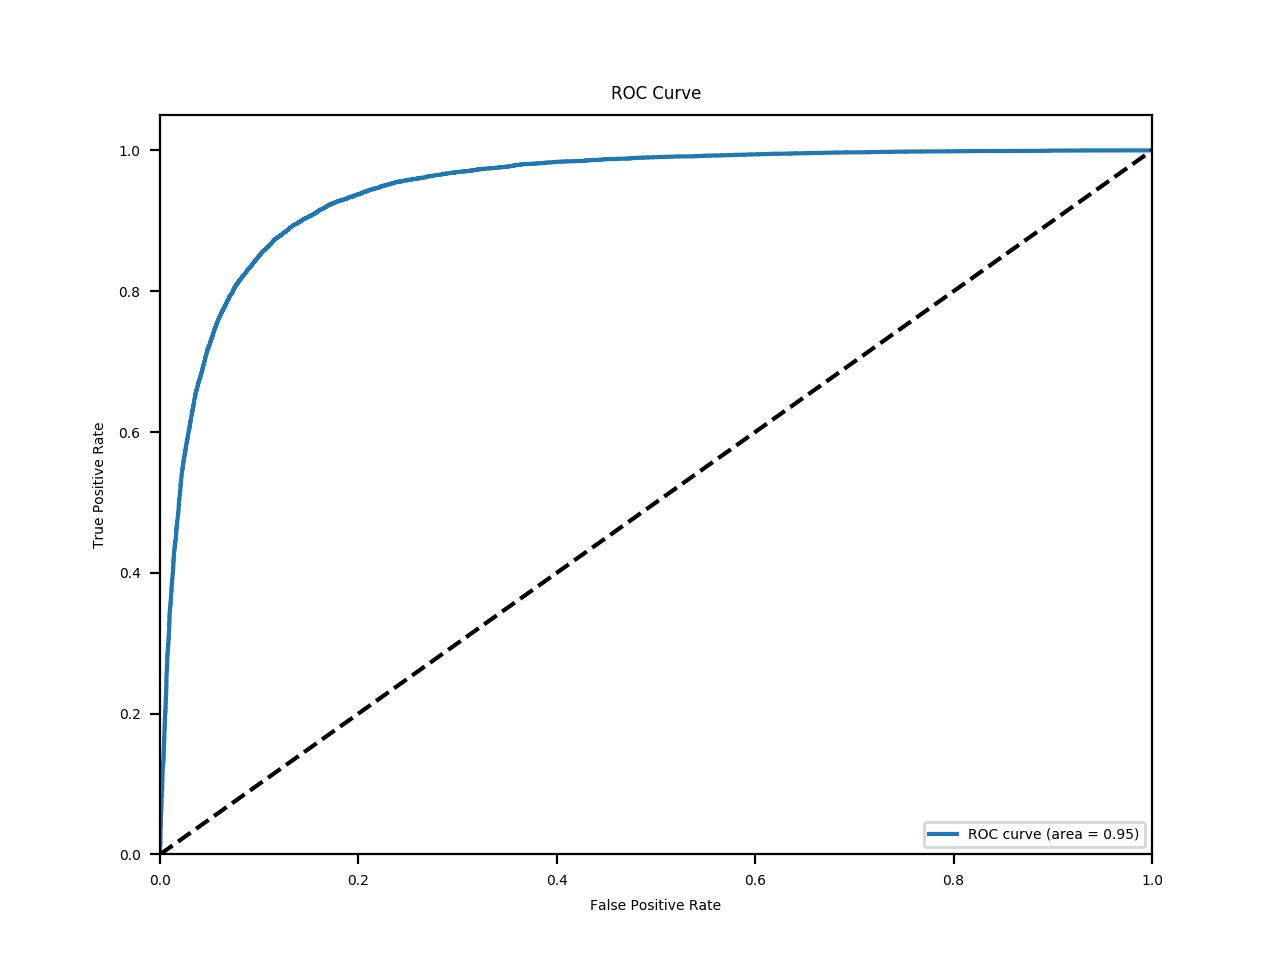

In [27]:
#Neural net with best identified parameters
import tensorflow
import random
from tflearn import DNN
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

def classifyNNbest():
    # Do we need to scale our data?
    # Peformance drops when I do this, if my 
    # Maybe because all data already on same scale?
    # Interestingly, and maybe not surprisingly

    scaler = StandardScaler()

    scaler.fit(cDataTrain)

    cDataTrainScaled = scaler.transform(cDataTrain)
    cDataTestScaled = scaler.transform(cDataTest)

    clf = MLPClassifier(solver='lbfgs', activation='logistic', max_iter=2000, hidden_layer_sizes=[20, 20])

    clf.fit(cDataTrainScaled, trainLabels)
        
    predictions = clf.predict(cDataTestScaled)
    print(predictions)

    precision = metrics.precision_score(testLabels,predictions)
    recall = metrics.recall_score(testLabels,predictions)
        
    print (precision, recall)

    tn, fp, fn, tp = metrics.confusion_matrix(testLabels, predictions).ravel()
    print("TN: %d, FP: %d, FN: %d, TP: %d" % (tn, fp, fn, tp))
    
    # Determine the false positive and true positive rates
    fpr, tpr, _ = roc_curve(testLabels, clf.predict_proba(cDataTestScaled)[:,1])

    # Calculate the AUC
    roc_auc = auc(fpr, tpr)
    print 'ROC AUC: %0.2f' % roc_auc

    # Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return predictions, clf, testLabels, cDataTestScaled

nnPred, nnModel, nnTestLabels, nnTestScaled = classifyNNbest()
